### Research on Garch

In [32]:
import pandas as pd
import random
close = pd.read_parquet("../../db/tw/Adj_close.parquet")
close.index = pd.to_datetime(close.index)
stock_list_total = list(close.columns)
random_num = [random.randint(0, len(stock_list_total)) for _ in range(100)]
stock_list = [stock_list_total[i] for i in random_num]
stock_list = stock_list_total[-100:]

In [33]:
import yfinance as yf
import statsmodels.api as sm
import warnings
# warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima_model import ARMA
resample_map = {
    "weekly": "W",
    "biweekly": "2W",
    "monthly": "M"
}

# params
train_end_str = "2019-01-01"
train_end = pd.to_datetime(train_end_str)
train_start = train_end - timedelta(days=365)

pct_change = close.pct_change(fill_method=None).dropna(how='all', axis=0)

(-529.7213556695767, -514.0903345536482)

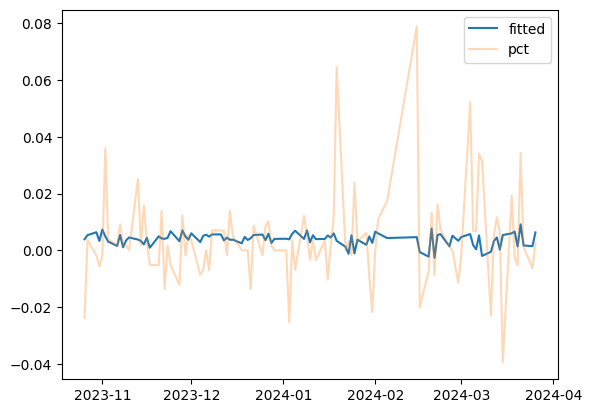

In [34]:
series = pct_change['2330.TW'].iloc[-150:-50]
model = sm.tsa.arima.ARIMA(series, order=(4, 0, 0)) # order = (ar_t, i_t, ma_t), for ar model only => ma_t = 0
model_fit = model.fit()
model_fit.summary()
plt.plot(model_fit.fittedvalues, alpha=1, label='fitted')
plt.plot(series, alpha=0.3, label='pct')
plt.legend()
model_fit.aic, model_fit.bic

(-10.130263627603323,
 8.956534199926078e-18,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 -463.84773944009476)

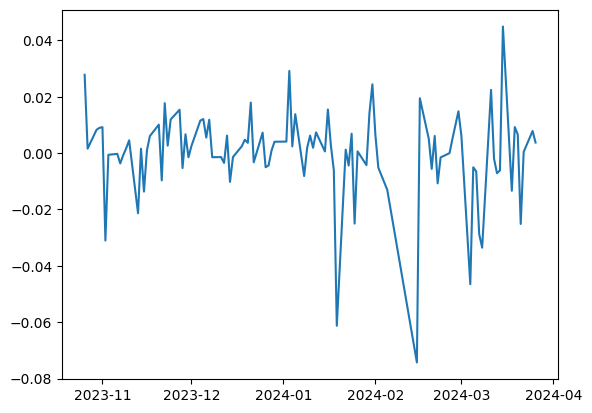

In [35]:
from statsmodels.tsa.stattools import adfuller

garch_data = model_fit.fittedvalues-series
plt.plot(garch_data)
adfuller(garch_data.dropna())

garch: predict next actual_value - prediction

and for ar model we get predicted value, 

+/- garch prediction of actual - prediction, we get actual prediction.

### Comparison: arima vs. arima garch

In [41]:
# loop through ar_t from 1 to 5
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

pct_change = close.pct_change(fill_method=None).dropna(how='all', axis=0)
pct_change.index = pd.to_datetime(pct_change.index)
'''
ar_t = 2
from ${from_t - backtest_interval} days before, 
with backtesting for ${backtest_interval} days each,
looping for ${iter} days as sample data to check accuracy
'''
ar_t = 2
from_t = 150
backtest_interval = 100
iter = from_t - backtest_interval
test = pct_change[['2330.TW']].iloc[-iter:]
for ar_t in range(1, 6):
    predictions = [0.0] * iter 
    for i in range(iter):
        train = pct_change['2330.TW'].iloc[-from_t+i:-from_t+backtest_interval+i]
        model = sm.tsa.arima.ARIMA(train, order=(ar_t, 0, 0))
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=1)
        predictions[i] = prediction.iloc[0]

    test[f'pred_{ar_t}'] = predictions
    
    # calc
    test['pos same'] = (test['2330.TW'] > 0) & (test[f'pred_{ar_t}'] > 0)
    test['neg same'] = (test['2330.TW'] < 0) & (test[f'pred_{ar_t}'] < 0)
    test['same dir'] = test['pos same'] | test['neg same']
    print(f"accuracy before garch for ar_t={ar_t}:", len(test[test['same dir'] == True])/len(test))

'''
# worse, accuracy around 0.3 from 2023-06 to 2023-12
# the pvalues have to be worse at that time interval, so the model could work
# for the stocks with no significant pvalues, set factor value to -1 or sth
'''
print("")

accuracy before garch for ar_t=1: 0.52
accuracy before garch for ar_t=2: 0.5
accuracy before garch for ar_t=3: 0.5
accuracy before garch for ar_t=4: 0.56
accuracy before garch for ar_t=5: 0.58



In [37]:
# test for best lags, maybe exclude other lags
t = 149
for i in range(5):
    train = pct_change['2330.TW'].iloc[-t+i:-t+100+i]
    model = sm.tsa.arima.ARIMA(train, order=(ar_t, 0, 0))
    model_fit = model.fit()
    prediction = model_fit.forecast(steps=1)
    print("===========")
    print(model_fit.pvalues.iloc[1:6])

ar.L1    0.601109
ar.L2    0.584096
ar.L3    0.968904
ar.L4    0.151602
ar.L5    0.266640
dtype: float64
ar.L1    0.618993
ar.L2    0.599465
ar.L3    0.936515
ar.L4    0.152526
ar.L5    0.201659
dtype: float64
ar.L1    0.606233
ar.L2    0.591512
ar.L3    0.907020
ar.L4    0.146995
ar.L5    0.199925
dtype: float64
ar.L1    0.611463
ar.L2    0.665042
ar.L3    0.882106
ar.L4    0.161712
ar.L5    0.221155
dtype: float64
ar.L1    0.561523
ar.L2    0.670858
ar.L3    0.934330
ar.L4    0.146044
ar.L5    0.221185
dtype: float64


In [38]:
# params for model_fit(summary)
summary = model_fit.summary()
coefficients = model_fit.params
standard_errors = model_fit.bse
p_values = model_fit.pvalues
aic = model_fit.aic
bic = model_fit.bic
p_values

const     6.985348e-03
ar.L1     5.615231e-01
ar.L2     6.708576e-01
ar.L3     9.343299e-01
ar.L4     1.460442e-01
ar.L5     2.211851e-01
sigma2    7.512556e-18
dtype: float64

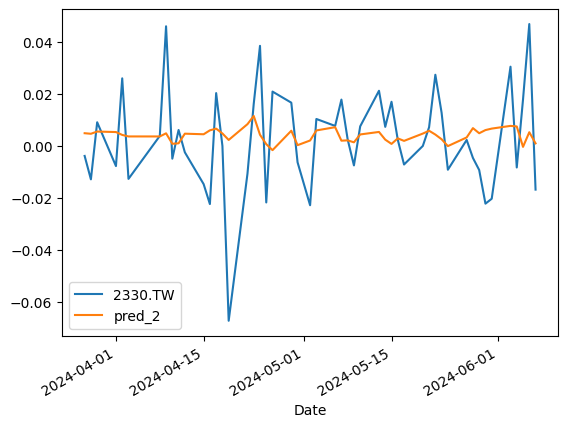

accuracy before garch: 0.5


In [39]:
# single plot actual - predict = residual, used for garch model
test['neg same'] = (test['2330.TW'] < 0) & (test['pred_2'] < 0)
test['pos same'] = (test['2330.TW'] > 0) & (test['pred_2'] > 0)
test['same dir'] = test['pos same'] | test['neg same']
test['2330.TW'].plot()
test['pred_2'].plot()
plt.legend()
plt.show()
print("accuracy before garch:", len(test[test['same dir'] == True])/len(test))